In [1]:
import pickle

import pandas as pd
import numpy as np
import optuna

from nam.data import NAMDataset, FoldedDataset
from nam.config import defaults
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('../data/clean_data.pickle', 'rb') as file:
    data_dict = pickle.load(file)

y = data_dict['y'].head(100)
X = data_dict['X'].head(100)

In [4]:
config = defaults()
config

namespace(device='cpu',
          seed=2021,
          data_path='data/GALLUP.csv',
          experiment_name='NAM',
          regression=False,
          num_epochs=1,
          lr=0.0003,
          batch_size=1024,
          logdir='output',
          wandb=True,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.5,
          decay_rate=0.995,
          l2_regularization=0.5,
          output_regularization=0.5,
          num_basis_functions=1000,
          units_multiplier=2,
          shuffle=True,
          cross_val=False,
          num_folds=5,
          num_splits=3,
          fold_num=1,
          num_models=1,
          num_workers=16,
          save_model_frequency=2,
          save_top_k=3,
          use_dnn=False,
          early_stopping_patience=50)

In [6]:
X.dtypes

CutoffLTV                  float64
CutoffDSCR                 float64
CutoffCpn                  float64
log_bal                    float64
fixed                      float64
buildingage                float64
CutoffOcc                  float64
year_priced                float64
quarter_type               float64
qy                         float64
Size                       float64
OVER_w                     float64
past_over                  float64
high_overstatement2        float64
AmortType_Balloon Amort      int64
AmortType_Fully Amort        int64
AmortType_IO                 int64
AmortType_Partial IO         int64
type_AGENCY-DUS              int64
type_Agency                  int64
type_Conduit                 int64
type_Large Loan              int64
type_Other                   int64
type_SASB                    int64
type_Small Bal               int64
Distress                    object
dtype: object

In [15]:
# Neural Additive Model
feature_cols = X.columns
X['Distress'] = y.astype(float)
config.logdir = 'NAM_testing'
# Ich brauch FoldedDataset, das macht Cross Validation
config.cross_val = True
nam_dataset = FoldedDataset(
    config,
    data_path=X,
    features_columns=feature_cols,
    targets_column=['Distress'],
)
nam_model = NAM(
    config=config,
    name='Testing_NAM',
    num_inputs=len(nam_dataset[0][0]),
    num_units=get_num_units(config, nam_dataset.features)
)
# NAM Training
data_loaders = nam_dataset.train_dataloaders()
for fold, (train_loader, val_loader) in enumerate(data_loaders):
     tb_logger = TensorBoardLogger(
          save_dir=config.logdir,
          name=f'{nam_model.name}',
          version=f'fold_{fold + 1}')

     checkpoint_callback = ModelCheckpoint(
          filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
          monitor='val_loss',
          save_top_k=config.save_top_k,
          mode='min'
     )
     litmodel = LitNAM(config, nam_model)
     pl.Trainer()
     trainer = pl.Trainer(
          logger=tb_logger,
          max_epochs=config.num_epochs,
          callbacks=checkpoint_callback,
     )
     trainer.fit(
          litmodel,
          train_dataloaders=train_loader,
          val_dataloaders=val_loader)

/var/folders/pr/tf6fbkqx6mv5m13cy7d765fw0000gn/T/ipykernel_22728/536610172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Distress'] = y.astype(float)
/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)
2023-09-06 14:07:49.892 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[1]: train: 57, val: 9
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), use

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, v_num=ld_1, train_loss_step=108.0, Accuracy_metric_step=0.000, val_loss_step=89.70, val_loss_epoch=89.70, Accuracy_metric_epoch=0.439, train_loss_epoch=108.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it, v_num=ld_1, train_loss_step=108.0, Accuracy_metric_step=0.000, val_loss_step=89.70, val_loss_epoch=89.70, Accuracy_metric_epoch=0.439, train_loss_epoch=108.0]


2023-09-06 14:07:53.534 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[2]: train: 57, val: 9
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 167 K 
-------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, v_num=ld_2, train_loss_step=106.0, Accuracy_metric_step=0.000, val_loss_step=89.20, val_loss_epoch=89.20, Accuracy_metric_epoch=0.544, train_loss_epoch=106.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, v_num=ld_2, train_loss_step=106.0, Accuracy_metric_step=0.000, val_loss_step=89.20, val_loss_epoch=89.20, Accuracy_metric_epoch=0.544, train_loss_epoch=106.0]


2023-09-06 14:07:54.364 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[3]: train: 57, val: 9
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 167 K 
-------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, v_num=ld_3, train_loss_step=107.0, Accuracy_metric_step=0.000, val_loss_step=89.20, val_loss_epoch=89.20, Accuracy_metric_epoch=0.526, train_loss_epoch=107.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, v_num=ld_3, train_loss_step=107.0, Accuracy_metric_step=0.000, val_loss_step=89.20, val_loss_epoch=89.20, Accuracy_metric_epoch=0.526, train_loss_epoch=107.0]


2023-09-06 14:07:55.193 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[4]: train: 57, val: 9
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 167 K 
-------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, v_num=ld_4, train_loss_step=104.0, Accuracy_metric_step=0.222, val_loss_step=89.00, val_loss_epoch=89.00, Accuracy_metric_epoch=0.386, train_loss_epoch=104.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s, v_num=ld_4, train_loss_step=104.0, Accuracy_metric_step=0.222, val_loss_step=89.00, val_loss_epoch=89.00, Accuracy_metric_epoch=0.386, train_loss_epoch=104.0]


2023-09-06 14:07:56.028 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[5]: train: 57, val: 9
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 167 K 
-------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, v_num=ld_5, train_loss_step=103.0, Accuracy_metric_step=0.667, val_loss_step=88.50, val_loss_epoch=88.50, Accuracy_metric_epoch=0.474, train_loss_epoch=103.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s, v_num=ld_5, train_loss_step=103.0, Accuracy_metric_step=0.667, val_loss_step=88.50, val_loss_epoch=88.50, Accuracy_metric_epoch=0.474, train_loss_epoch=103.0]


In [ ]:
import tensorboard

In [9]:
trainer.logger.experiment.summary

AttributeError: 'SummaryWriter' object has no attribute 'summary'

In [10]:
trainer.test(litmodel, dataloaders=nam_dataset.test_dataloaders())

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Accuracy_metric_epoch             1.0
     test_loss_epoch         88.22645568847656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 88.22645568847656, 'Accuracy_metric_epoch': 1.0}]

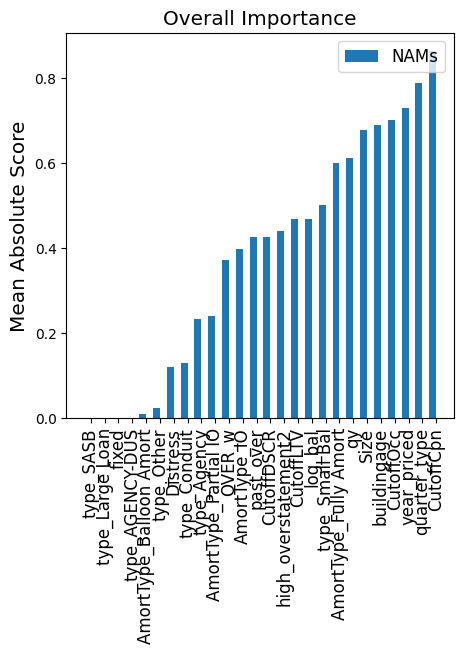

In [11]:
fig = plot_mean_feature_importance(litmodel.model, nam_dataset)

ValueError: num must be an integer with 1 <= num <= 24, not 25

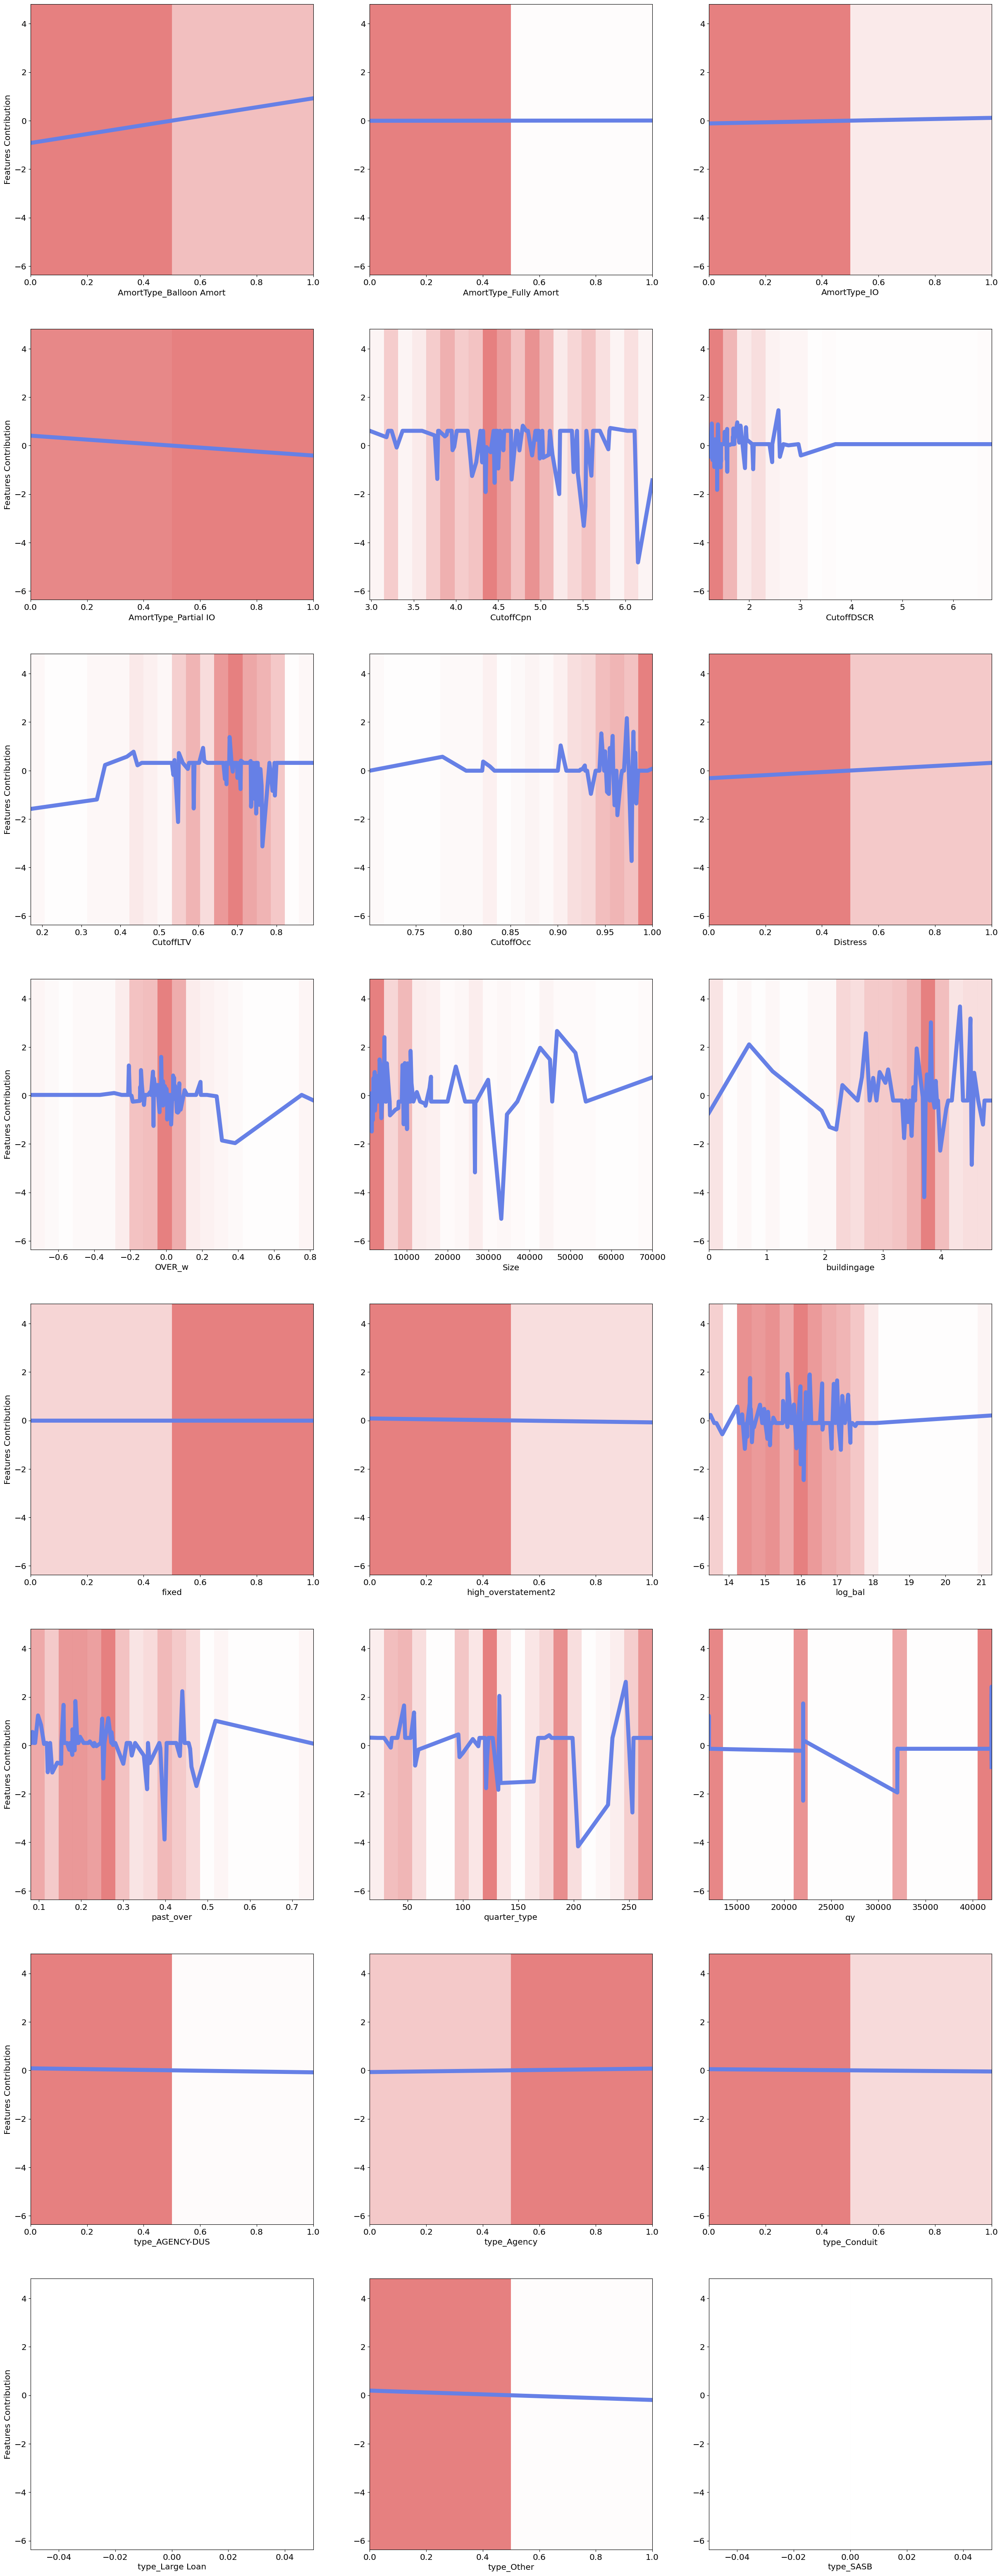

In [13]:
# fig = plot_nams(litmodel.model, nam_dataset, num_cols=3)
fig = plot_nams(litmodel.model, nam_dataset, num_cols=3)